# Uncertainty estimation using ensembles of partly independent MLP models

-- Network outputs two values in the final layer, corresponding to the predicted **mean** and **variance** by treating the observed value as a sample from a Gaussian distribution

-- Ensemble members are trained on different bootstrap samples of the original training set


The mean and variance of a mixture are given by $\mu_{*}(\mathbf{x})=M^{-1} \sum_{m} \mu_{\theta_{m}}(\mathbf{x})$ and $\sigma_{*}^{2}(\mathbf{x})=M^{-1} \sum_{m}\left(\sigma_{\theta_{m}}^{2}(\mathbf{x})+\mu_{\theta_{m}}^{2}(\mathbf{x})\right)-\mu_{*}^{2}(\mathbf{x})$ respectively.


In [1]:
import sys, os, glob
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from astropy.io import fits
import numpy.ma as ma
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.models_mlp import MlpPartlyIndepNet
from inverse_problem.nn_inversion.transforms import normalize_output
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer
from inverse_problem.nn_inversion.transforms import transform_dist
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
from inverse_problem.nn_inversion.posthoc import plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion import mlp_transform_rescale, normalize_spectrum

### Define ensemble size

In [4]:
ensemble_size = 10

### Load data

In [5]:
filename = '../data/parameters_base_new.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

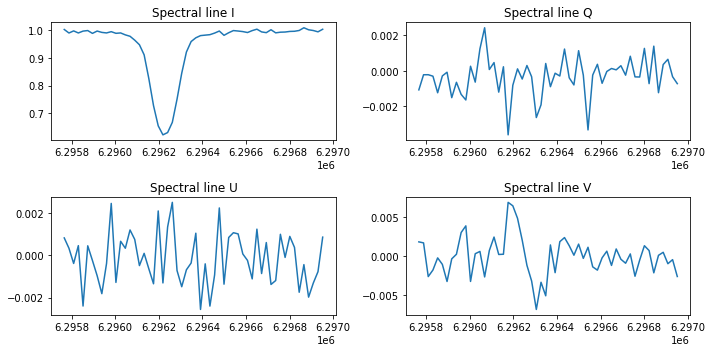

In [6]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Prepare data for training

Options:
-- angle transformation
-- log transformation

In [7]:
params = fits.open(filename)[0].data
def params_masked_rows(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])
    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)


def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

In [8]:
MLP  = True
factors, cont_scale = [1,1000,1000,1000], 40000
angle_transformation, logB = False, True


if MLP:
    transform_name = "mlp_transform_rescale"
    batch_size = 20
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name,
                                           factors = factors, cont_scale = cont_scale,
                                           logB = logB, angle_transformation = angle_transformation,
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
else:
    transform_name = "conv1d_transform_rescale"
    batch_size = 128
    train_loader, val_loader = make_loader(filename=filename, transform_name=transform_name,
                                           factors = factors, cont_scale = cont_scale,
                                           logB = logB, angle_transformation = angle_transformation,
                                           batch_size=128)
    sample_batch = next(iter(train_loader))
    print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)


torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])


In [9]:
data_loader = [make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors = factors, cont_scale= cont_scale,
                                       angle_transformation = angle_transformation, logB = logB,
                                       batch_size=128) for _ in range(ensemble_size)]

# print characteristics for the first model in the ensemble
sample_batch = next(iter(data_loader[0][0]))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(data_loader[0][0])}, for validation: {len(data_loader[0][1])}")

torch.Size([128, 224]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 31243, for validation: 3472


### Create path for saving

In [9]:
model_name = 'unc_pred'
current_time = str(datetime.now().strftime('%m-%d_%H-%M'))
save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../unc_pred_03-16_13-09/'

### Define ensemble

output_dim=22 for uncertainty estimation

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = [MlpPartlyIndepNet(input_dim=224, output_dim=22, hidden_dims=[200, 200, 200],
                              activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2).to(device) for _ in range(ensemble_size)]

In [11]:
criterion = nn.MSELoss()
optimizers = [torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99)) for model in ensemble]

In [10]:
def mdn_cost(mu, sigma, y):
    dist = torch.distributions.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))


def fit_step(model, optimizer, dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            optimizer.zero_grad()

            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1
            if train_it % 10 == 0:
                pbar_outer.update(10)
        return train_loss / train_it


def eval_step(model, dataloader, max_steps = None):
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps,len(dataloader))
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        if i==total:
            break
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).msean()
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it

In [11]:
def save_model(model, optimizer, epoch, loss, path='../'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + f'ep{epoch}.pt')

### Train model

In [12]:
# %%time
# max_train_steps = 500
# max_val_steps = 100
# best_valid_loss = [float('inf') for i in range(ensemble_size)]
#
# history = [[] for i in range(ensemble_size)]
# loss_history = [[] for i in range(ensemble_size)]
#
# log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
# n_epochs = 1
# log_dir=save_path
#
#
# with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
#     for epoch in range(n_epochs):
#         val_losses = []
#         train_losses = []
#         for i, model in enumerate(ensemble):
#             optimizer = optimizers[i]
#             train_loss = fit_step(model, optimizer, data_loader[i][0], max_train_steps)
#             val_loss = eval_step(model, data_loader[i][1], max_val_steps)
#
#             history.append((train_loss, val_loss))
#             if val_loss < best_valid_loss[i]:
#                 best_valid_loss[i] = val_loss
#                 save_model(model, optimizer, epoch, val_loss, save_path + 'model_' + str(i) + '_')
#
#             val_losses.append(val_loss)
#             train_losses.append(train_loss)
#
#
#         val_loss, train_loss = min(val_losses), min(train_losses)
#         pbar_outer.update(1)
#         tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
#                                                v_loss=val_loss))
#

### Load the ensemble weights

In [21]:
save_path = '../unc_pred_ens_02-28_23-39/'
n_epochs = 4

for i, model in enumerate(ensemble):
    model.load_state_dict(torch.load(save_path + 'model_' + str(i) + '_ep' + str(n_epochs - 1) + '.pt', map_location=device)['model_state_dict'])

## Results analysis
### Simulation based on the refer file

Data source: https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [22]:
path_to_refer = '../data/sp_20140926_170005/20140926_170005.fits'
data, names = open_param_file(path_to_refer, normalize=True, angle_transformation = angle_transformation, logB = logB)
print(data.shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift
(512, 873, 11)


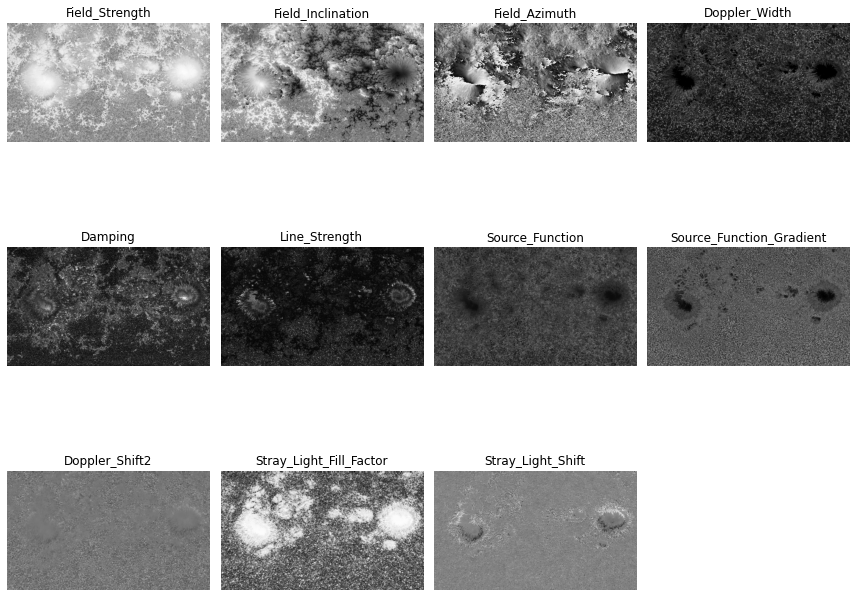

In [23]:
plot_params(data, names=names)

In [24]:
%%time
transform = mlp_transform_rescale(factors = factors, angle_transformation=angle_transformation,
                                  cont_scale=cont_scale, logB = logB)
test_dataset = PregenSpectrumDataset(param_path=path_to_refer, source='refer', transform=transform)


CPU times: user 37.8 s, sys: 22.7 s, total: 1min
Wall time: 1min 9s


In [15]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [63]:
%%time

predicted_mean = np.zeros((ensemble_size, 446976, 11))
predicted_sigma = np.zeros((ensemble_size, 446976, 11))

for i, model in enumerate(ensemble):
    model.eval()
    with torch.no_grad():
        predicted = model(sim_x)

    predicted_mean[i] = predicted[:, :11].detach().cpu().numpy()
    predicted_sigma[i] = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

CPU times: user 4min 36s, sys: 46.6 s, total: 5min 23s
Wall time: 3min 44s


In [26]:
refer_unnormalized, names = open_param_file(path_to_refer, normalize=False)
ref_unnormalized_2d = refer_unnormalized.reshape(-1, 11)

refer_shape = refer_unnormalized.shape

print('\n', refer_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


In [27]:
ref_2d = normalize_output(ref_unnormalized_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation)

refer = ref_2d.reshape(refer_shape).copy()

In [28]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)
masked_ref_unnormalized_2d = create_masked_array(ref_unnormalized_2d)
masked_ref_unnormalized = masked_ref_unnormalized_2d.reshape(refer.shape)

In [64]:
compute_metrics(masked_ref_2d.data, predicted_mean[1],
                save_path=save_path + 'metrics.csv',
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.9473,0.0008,0.0179
Field Inclination,0.9820,0.0007,0.0154
Field Azimuth,0.7242,0.0211,0.0690
Doppler Width,0.9146,0.0013,0.0241
Damping,0.8870,0.0018,0.0266
Line Strength,0.6431,0.0027,0.0229
S_0,0.8028,0.0008,0.0205
S_1,0.9584,0.0004,0.0138
Doppler Shift,0.9299,0.0001,0.0056
Filling Factor,0.7964,0.0121,0.0772


In [46]:
from inverse_problem.nn_inversion.transforms import inverse_transformation_unc, inverse_transformation
from inverse_problem.nn_inversion.posthoc import plot_fitting_curves_unc
inv_angle_transformation = angle_transformation

In [178]:
# plot_analysis_hist2d_unc(true, pred, sigma, index=2, bins=300, save_path=save_path, title='refer_one_model');

In [52]:
predicted_mean_norm = predicted_mean.copy()
predicted_sigma_norm = predicted_sigma.copy()

predicted_mean_norm[0], predicted_sigma_norm[0] = inverse_transformation_unc(predicted_mean[0], predicted_sigma[0], inv_angle_transformation=inv_angle_transformation)
true = inverse_transformation(masked_ref_2d.data, inv_angle_transformation=inv_angle_transformation)

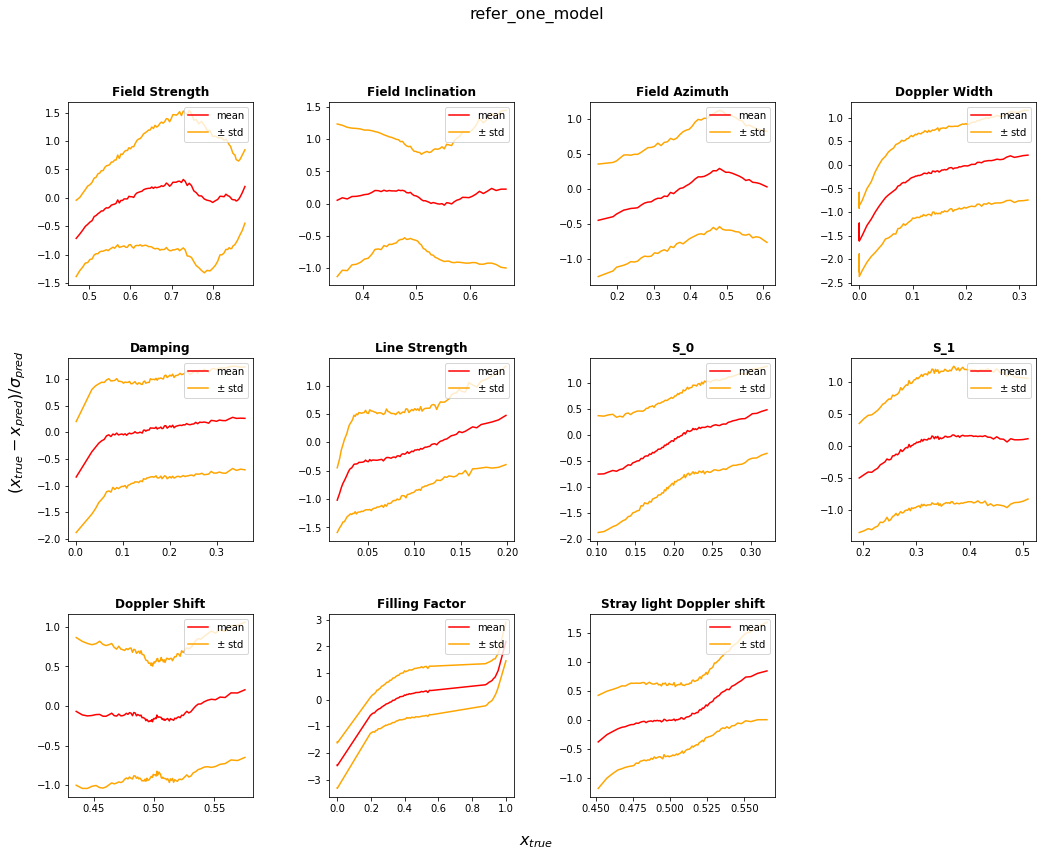

In [182]:
plot_fitting_curves_unc(masked_ref_2d.data, predicted_mean[0], predicted_sigma[0], save_path=save_path, title='refer_one_model')

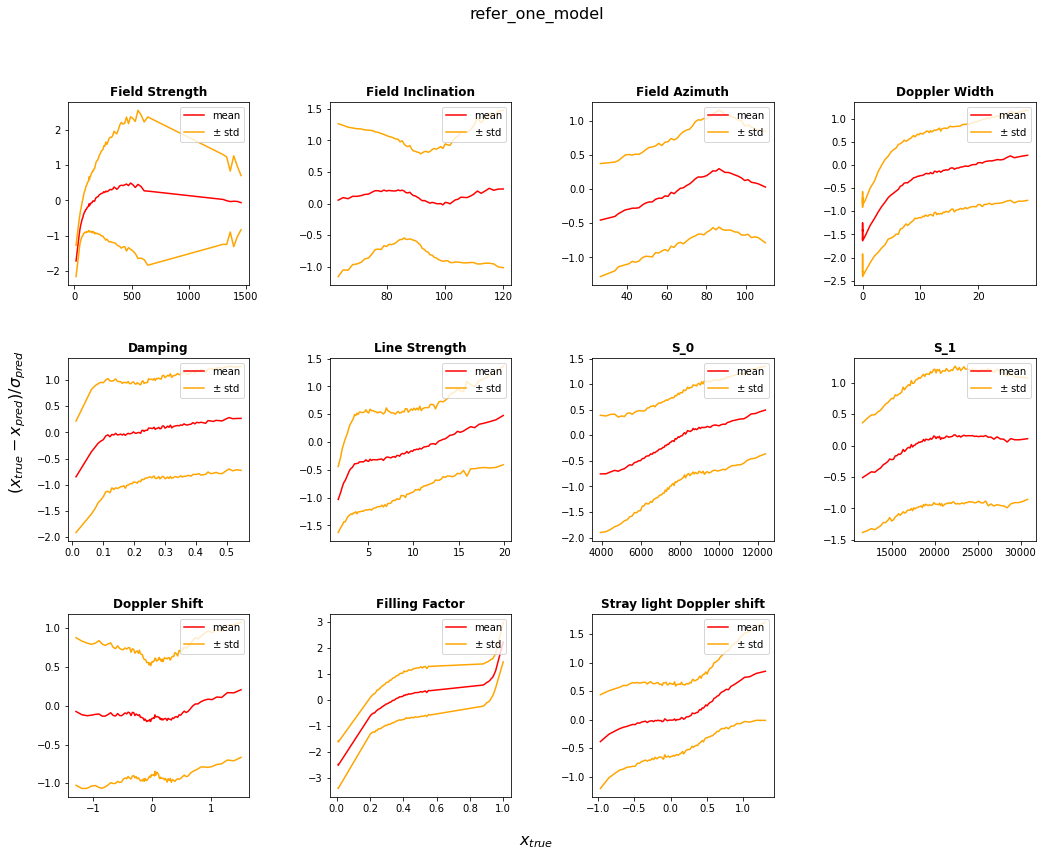

In [206]:
plot_fitting_curves_unc(true, predicted_mean_norm[0], predicted_sigma_norm[0], save_path=save_path, title='refer_one_model')

### Ensemble results

In [ ]:
predicted_mean_overall = np.mean(predicted_mean, axis = 0)
predicted_sigma_overall  = np.sqrt(np.mean(np.square(predicted_sigma) + np.square(predicted_mean), axis = 0) - np.square(predicted_mean_overall))

In [186]:
predicted_mean_norm_overall, predicted_sigma_norm_overall = inverse_transformation_unc(predicted_mean_overall, predicted_sigma_overall, inv_angle_transformation=inv_angle_transformation)

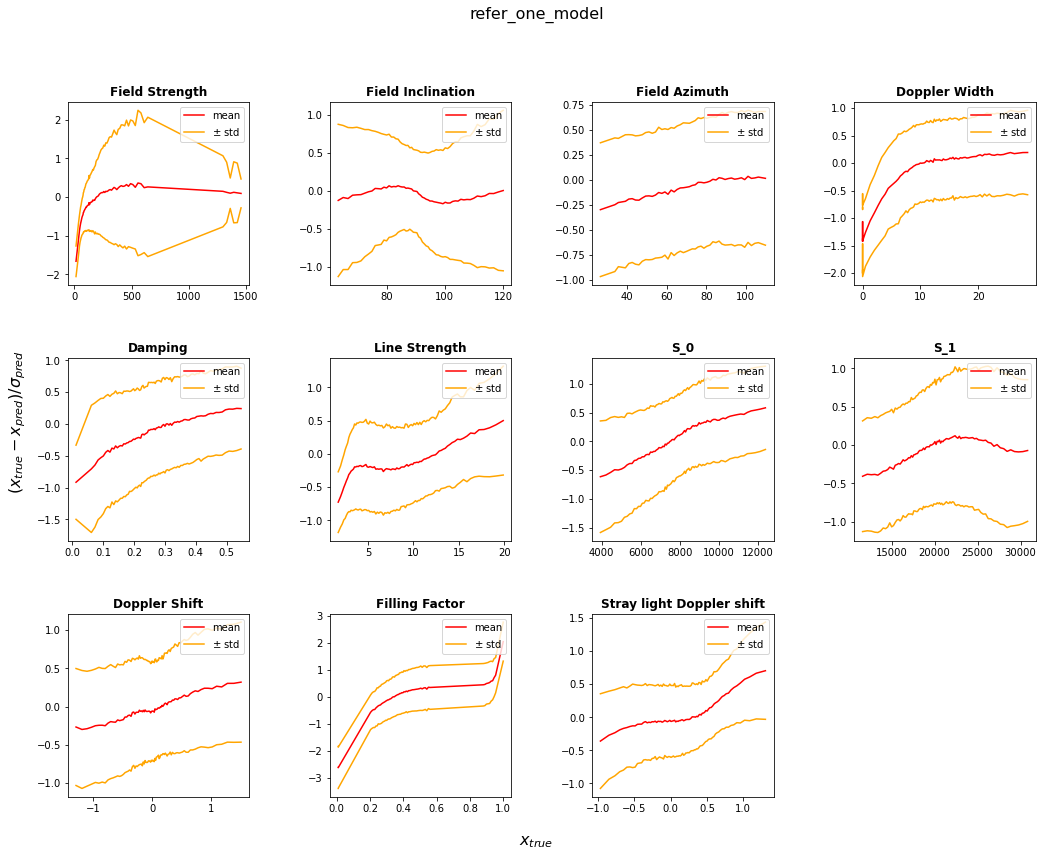

In [188]:
plot_fitting_curves_unc(true, predicted_mean_norm_overall, predicted_sigma_norm_overall, save_path=save_path, title='refer_one_model')

### Real spectra
Data source: https://csac.hao.ucar.edu/fg_download.php

In [189]:
path_to_folder = '../data/'
#date as a list with year, month,day, hour
date = ['2014','09','26','17']
sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')
sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]
sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [190]:
def open_spectrum_data(sp_folder, date, idx):
    sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
    sp_path = glob.glob(f'{sp_path}/*/')[0]
    sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
    return fits.open(sp_lines[idx])
def real_spectra(spectra_file):
    real_I = spectra_file[0].data[0][:,56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][:,56:].astype('float64')
    real_U = spectra_file[0].data[2][:,56:].astype('float64')
    real_V = spectra_file[0].data[3][:,56:].astype('float64')
    return np.concatenate((real_I, real_Q, real_U, real_V), axis = 1)

Real spectrum for parameters
Model spectrum for parameters
Field_Strength: 483.10, Field_Inclination: 127.89, Field_Azimuth: 67.10, Doppler_Width: 25.90, Damping: 0.33, Line_Strength: 10.72, Source_Function: 8626.69, Source_Function_Gradient: 21277.41, Doppler_Shift2: -0.11, Stray_Light_Fill_Factor: 0.46, Stray_Light_Shift: -0.13


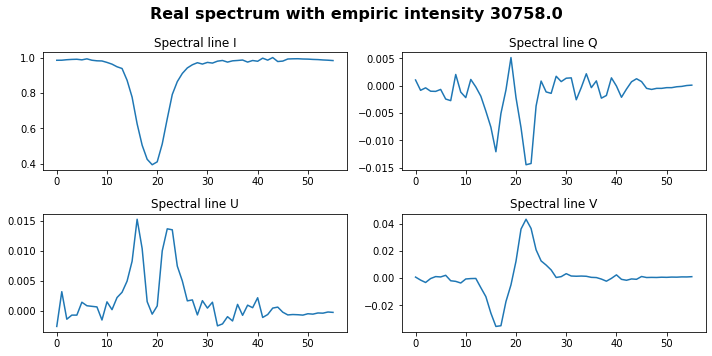

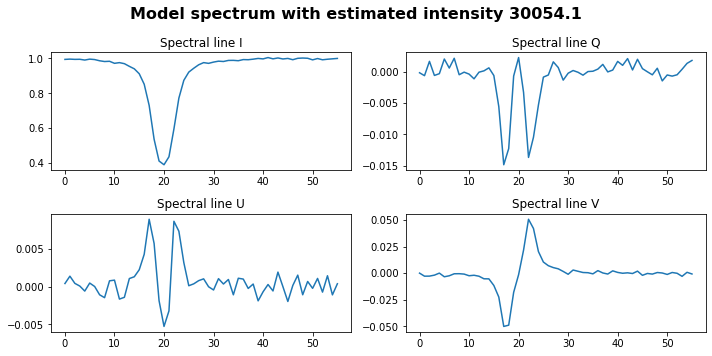

In [191]:
idx_0, idx_1 = 22, 794
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int  = plot_model_spectrum(refer, names, idx_0, idx_1)

In [192]:
def prepare_real_mlp(sp_folder, date, factors = None, cont_scale = None, device = None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1,56,4), order='F'), factors = factors)
    norm_cont = cont/cont_scale
    norm_real_samples = np.reshape(norm_real_samples, (-1,224), order='F')
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x


In [193]:
%%time
real_x = prepare_real_mlp(sp_folder, date, factors = factors, cont_scale = cont_scale, device = device)

CPU times: user 3.44 s, sys: 2.07 s, total: 5.51 s
Wall time: 8.17 s


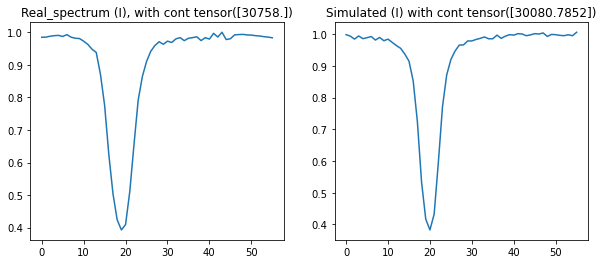

In [194]:
idx = 20000
idx_0, idx_1  = np.where(np.arange(512*873).reshape(512, 873)==idx)
idx_0[0], idx_1[0] = idx_0, idx_1
plt.figure(figsize = (10,4))
plt.subplot(1,2,1); plt.plot(real_x[0][idx, :56]); plt.title(f'Real_spectrum (I), with cont {real_x[1][idx]*40000}')
plt.subplot(1,2,2);  plt.plot(sim_x[0][idx, :56]); plt.title(f'Simulated (I) with cont {sim_x[1][idx]*40000}');


In [195]:
%%time

predicted_mean_real = np.zeros((ensemble_size, 446976, 11))
predicted_sigma_real = np.zeros((ensemble_size, 446976, 11))

for i, model in enumerate(ensemble):
    model.eval()
    with torch.no_grad():
        predicted = model(real_x)

    predicted_mean_real[i] = predicted[:, :11].detach().cpu().numpy()
    predicted_sigma_real[i] = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

CPU times: user 4min 38s, sys: 48.9 s, total: 5min 27s
Wall time: 3min 47s


In [196]:
compute_metrics(ref_2d, predicted_mean_real[1],
                save_path=save_path + 'metrics.csv',
                mask=masked_ref_2d.mask)

,r2,mse,mae
Field Strength,0.8406,0.0030,0.0395
Field Inclination,0.9705,0.0012,0.0241
Field Azimuth,0.6291,0.0285,0.0928
Doppler Width,0.2554,0.0155,0.0905
Damping,0.1828,0.0207,0.1110
Line Strength,0.4014,0.0048,0.0410
S_0,0.2261,0.0032,0.0426
S_1,0.6427,0.0038,0.0469
Doppler Shift,0.6159,0.0019,0.0374
Filling Factor,0.4259,0.0450,0.1561


In [197]:
predicted_mean_norm_real = predicted_mean_real.copy()
predicted_sigma_norm_real = predicted_sigma_real.copy()

In [200]:
predicted_mean_norm_real[0], predicted_sigma_norm_real[0] = inverse_transformation_unc(predicted_mean_real[0], predicted_sigma_real[0], inv_angle_transformation=inv_angle_transformation)

In [201]:
true_real = inverse_transformation(ref_2d, inv_angle_transformation=inv_angle_transformation)

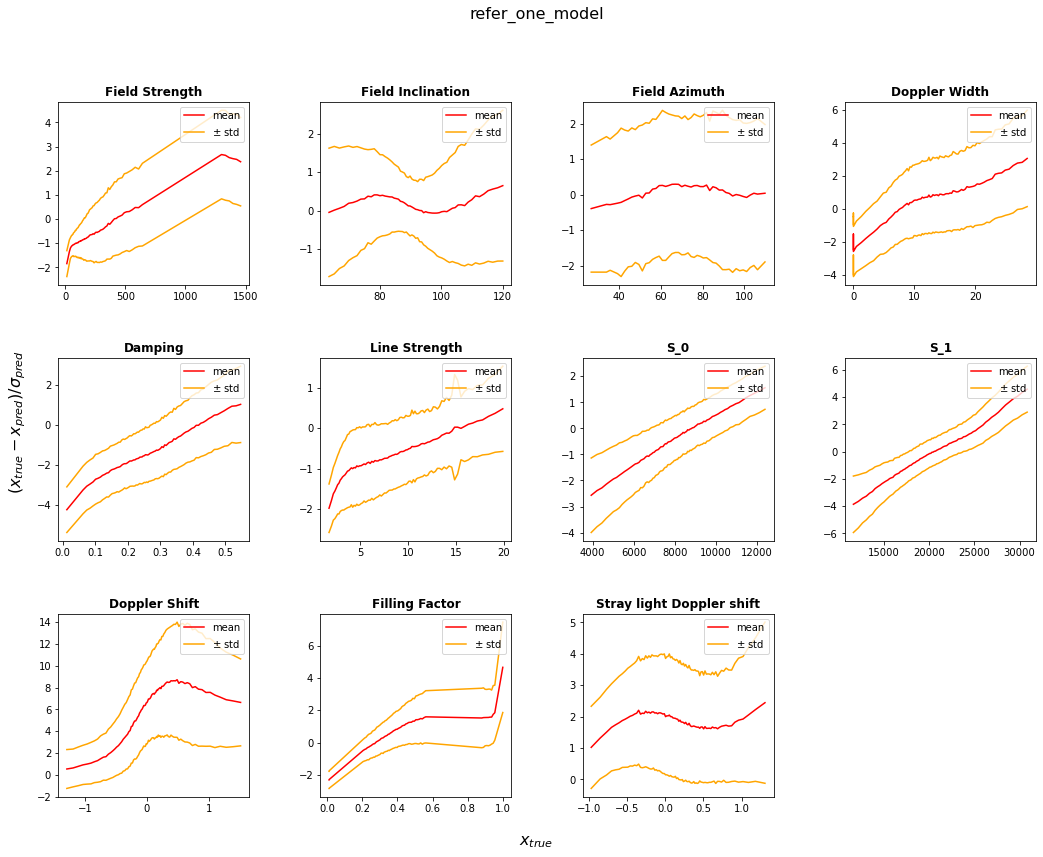

In [202]:
plot_fitting_curves_unc(true_real, predicted_mean_norm_real[0], predicted_sigma_norm_real[0], save_path=save_path, title='refer_one_model')

In [203]:
predicted_mean_overall_real = np.mean(predicted_mean_real, axis = 0)
predicted_sigma_overall_real  = np.sqrt(np.mean(np.square(predicted_sigma_real) + np.square(predicted_mean_real), axis = 0) - np.square(predicted_mean_overall_real))

In [204]:
predicted_mean_overall_norm_real, predicted_sigma_overall_norm_real = inverse_transformation_unc(predicted_mean_overall_real, predicted_sigma_overall_real, inv_angle_transformation=inv_angle_transformation)

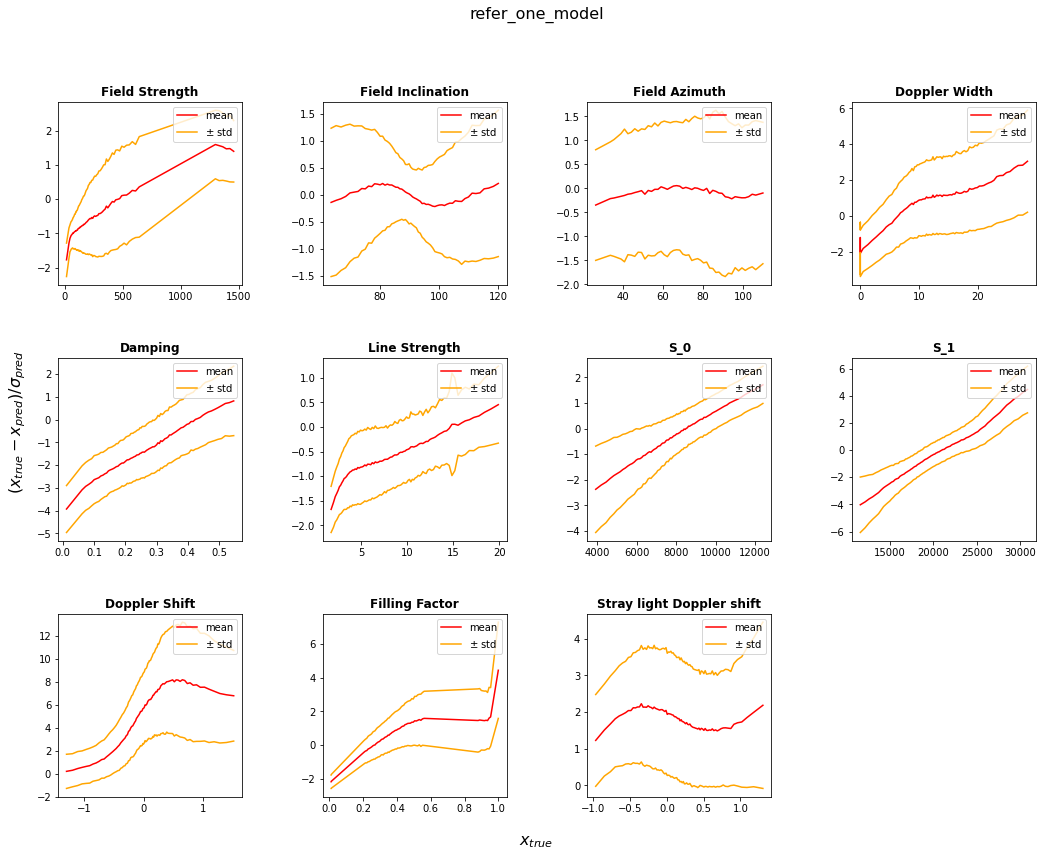

In [205]:
plot_fitting_curves_unc(true_real, predicted_mean_overall_norm_real, predicted_sigma_overall_norm_real, save_path=save_path, title='refer_one_model')